<a href="https://colab.research.google.com/github/vasudhab21/ML-LAB/blob/main/ML_Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the EXACT project paths from your video
project_path = '/content/drive/MyDrive/GenomeDetector'
# IMPORTANT: We are now using the 'natural2' folder
natural_data_path = os.path.join(project_path, 'data', 'natural2')
engineered_data_path = os.path.join(project_path, 'data', 'engineered')

# Install the necessary library
!pip install biopython

print("Environment is ready. Paths are set to your 'natural2' and 'engineered' folders.")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 27.2 MB/s eta 0:00:00
Environment is ready. Paths are set to your 'natural2' and 'engineered' folders.


In [4]:
import numpy as np
from itertools import product
from Bio import SeqIO
import glob
import os
import gzip

def get_kmer_features(k):
    # Generates all possible k-mers for a given k
    letters = ['A', 'C', 'G', 'T']
    return sorted([''.join(p) for p in product(letters, repeat=k)])

def sequence_to_kmer_counts(sequence, k, kmer_features):
    # Converts a DNA sequence into a vector of k-mer counts
    kmer_counts = {kmer: 0 for kmer in kmer_features}
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k].upper()
        if kmer in kmer_counts:
            kmer_counts[kmer] += 1
    return list(kmer_counts.values())

K_VALUE = 4
kmer_features = get_kmer_features(K_VALUE)
X, y = [], []

print("Loading 'Natural' genomes from the 'natural2' folder...")
search_pattern_natural = f"{natural_data_path}/*.fna*"
natural_files = glob.glob(search_pattern_natural)

for filepath in natural_files:
    handle = gzip.open(filepath, "rt") if filepath.endswith(".gz") else open(filepath, "r")
    for record in SeqIO.parse(handle, "fasta"):
        if len(record.seq) > 1000:
            X.append(sequence_to_kmer_counts(str(record.seq), K_VALUE, kmer_features))
            y.append(0)
    handle.close()

print("Loading 'Engineered' genomes from the 'engineered' folder...")
search_pattern_engineered = f"{engineered_data_path}/*.fasta"
engineered_files = glob.glob(search_pattern_engineered)

for filepath in engineered_files:
    for record in SeqIO.parse(filepath, "fasta"):
        if 200 < len(record.seq) < 50000:
            X.append(sequence_to_kmer_counts(str(record.seq), K_VALUE, kmer_features))
            y.append(1)

X = np.array(X)
y = np.array(y)

print("\n--- Data Processing Complete! ---")
print(f"Shape of our final feature matrix X: {X.shape}")
print(f"Shape of our final label vector y: {y.shape}")
print(f"Number of Natural samples (class 0): {np.sum(y == 0)}")
print(f"Number of Engineered samples (class 1): {np.sum(y == 1)}")

Loading 'Natural' genomes from the 'natural2' folder...
Loading 'Engineered' genomes from the 'engineered' folder...

--- Data Processing Complete! ---
Shape of our final feature matrix X: (17168, 256)
Shape of our final label vector y: (17168,)
Number of Natural samples (class 0): 16302
Number of Engineered samples (class 1): 866



A1: Confusion Matrix and Evaluation Metrics
Train Confusion Matrix:
 [[13031     2]
 [   21   680]]
Train Precision: 0.998, Recall: 0.998, F1: 0.998
Test Confusion Matrix:
 [[3265    4]
 [  10  155]]
Test Precision: 0.996, Recall: 0.996, F1: 0.996

Inference: Model shows a REGULAR FIT.

A7: Best k found using GridSearchCV 
{'n_neighbors': 1} with CV accuracy: 0.9981068932777358


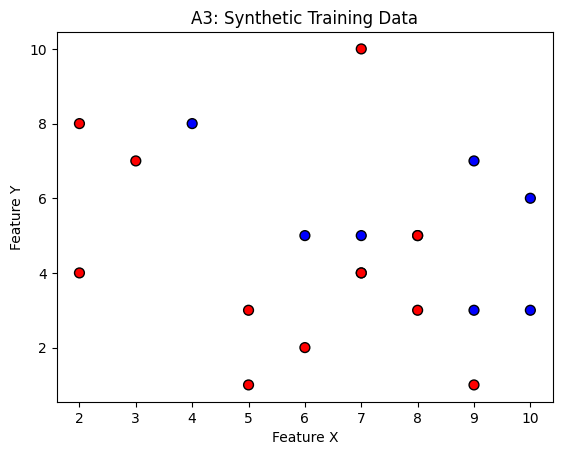

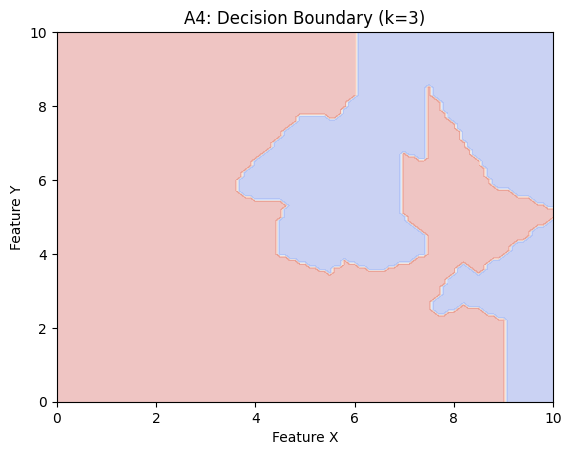

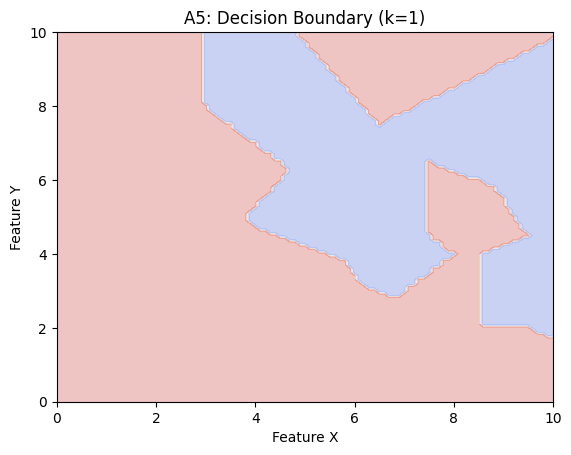

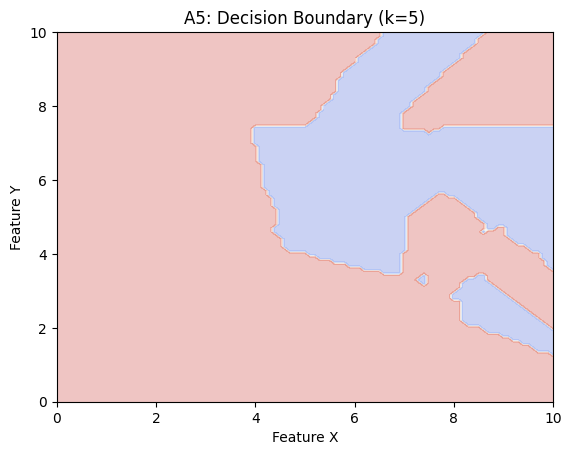

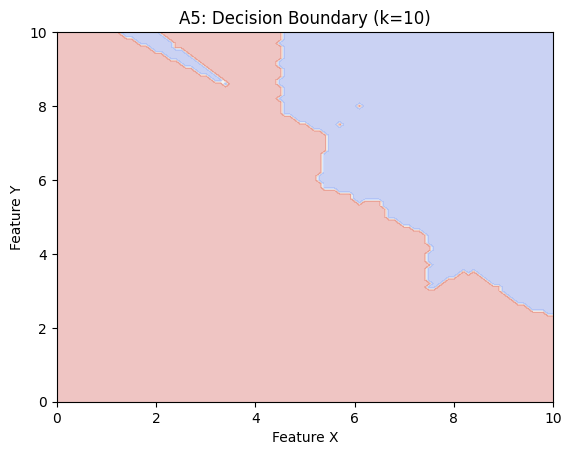

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score
)


def split_dataset(X, y, test_size=0.2, random_state=42):
  # Splitting data into train and test
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def evaluate_classifier(y_true, y_pred):
    # Computing the evaluation metrics
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, precision, recall, f1

def regression_metrics(y_true, y_pred):
    # Calculating errors
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mape, r2

def generate_synthetic_training_data(n_points=20, random_state=42):
    # Generates random 2D data
    np.random.seed(random_state)
    X = np.random.randint(1, 11, (n_points, 2))
    y = np.random.randint(0, 2, n_points)
    return X, y

def plot_training_data(X, y, title="Training Data"):
    # Scatter plot of 2D training data
    colors = ['blue' if label == 0 else 'red' for label in y]
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=50, edgecolors='k')
    plt.xlabel("Feature X")
    plt.ylabel("Feature Y")
    plt.title(title)
    plt.show()

def generate_test_grid(step=0.1):
    # Generates a dense grid for test data
    xx, yy = np.meshgrid(np.arange(0, 10.1, step), np.arange(0, 10.1, step))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    return xx, yy, grid_points

def plot_decision_boundary(xx, yy, Z, title="Decision Boundary"):
    # Plots decision boundary from predictions on a meshgrid
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.xlabel("Feature X")
    plt.ylabel("Feature Y")
    plt.title(title)
    plt.show()

def knn_with_hyperparam_search(X_train, y_train, method="grid"):
    # Finds best k using GridSearchCV or RandomizedSearchCV
    param_grid = {"n_neighbors": list(range(1, 20))}
    knn = KNeighborsClassifier()

    if method == "grid":
        search = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy")
    else:
        search = RandomizedSearchCV(knn, param_grid, n_iter=10, cv=5, scoring="accuracy", random_state=42)

    search.fit(X_train, y_train)
    return search.best_params_, search.best_score_


def main_project_workflow(X, y):
    # Split dataset
    X_train, X_test, y_train, y_test = split_dataset(X, y)

    # Train a basic kNN
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)

    # A1: Confusion matrix & metrics
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    cm_train, p_train, r_train, f1_train = evaluate_classifier(y_train, y_train_pred)
    cm_test, p_test, r_test, f1_test = evaluate_classifier(y_test, y_test_pred)

    print("\nA1: Confusion Matrix and Evaluation Metrics")
    print("Train Confusion Matrix:\n", cm_train)
    print(f"Train Precision: {p_train:.3f}, Recall: {r_train:.3f}, F1: {f1_train:.3f}")
    print("Test Confusion Matrix:\n", cm_test)
    print(f"Test Precision: {p_test:.3f}, Recall: {r_test:.3f}, F1: {f1_test:.3f}")

    if f1_train > f1_test + 0.1:
        print("\nInference: Model shows signs of OVERFITTING.")
    else:
        print("\nInference: Model shows a REGULAR FIT.")

    # A7: Hyperparameter tuning
    best_params, best_score = knn_with_hyperparam_search(X_train, y_train, method="grid")
    print("\nA7: Best k found using GridSearchCV ")
    print(best_params, "with CV accuracy:", best_score)

def main_synthetic_workflow():
    # A3: Training data
    X_train, y_train = generate_synthetic_training_data()
    plot_training_data(X_train, y_train, title="A3: Synthetic Training Data")

    # A4: Test grid classification
    xx, yy, grid_points = generate_test_grid()
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    Z = knn.predict(grid_points)
    plot_decision_boundary(xx, yy, Z, title="A4: Decision Boundary (k=3)")

    # A5: Repeat for different k
    for k in [1, 5, 10]:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        Z = knn.predict(grid_points)
        plot_decision_boundary(xx, yy, Z, title=f"A5: Decision Boundary (k={k})")

main_project_workflow(X, y)
main_synthetic_workflow()
